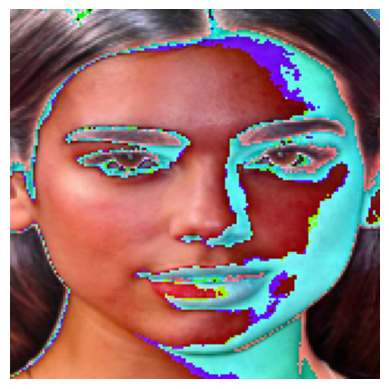

Cosine similarity: 0.809868574142456


In [11]:
from facenet_pytorch import InceptionResnetV1, MTCNN
from PIL import Image, ImageDraw
import torch
import matplotlib.pyplot as plt
import torchvision.transforms as T

# Load the pre-trained FaceNet model
model = InceptionResnetV1(pretrained='vggface2').eval()

# Load and allign face with MTCNN
mtcnn = MTCNN(image_size=160, margin=20, keep_all=False)

# Load and preprocess images
img = Image.open('face4.jpg')
face_tensor = mtcnn(img) #outputs 3x160x160 tensor
img2 = Image.open('face5.jpg')
face2_tensor = mtcnn(img2)

with torch.no_grad():
    emb1 = model(face_tensor.unsqueeze(0))
    emb2 = model(face2_tensor.unsqueeze(0))

to_pil = T.ToPILImage()
face_pil = to_pil(face_tensor)
plt.imshow(face_pil)
plt.axis('off')
plt.show()

# Cosine similarity
sim = torch.nn.functional.cosine_similarity(emb1, emb2).item()
print("Cosine similarity:", sim)

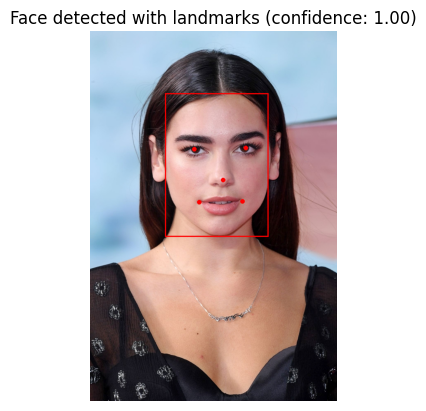

In [12]:
# Get bounding box and facial landmarks
boxes, probs, landmarks = mtcnn.detect(img, landmarks=True)


img_draw = img.copy()
draw = ImageDraw.Draw(img_draw)

if boxes is not None and landmarks is not None:
    # Draw bounding box
    draw.rectangle(boxes[0].tolist(), outline='red', width=3)

    # Draw landmarks (5 points: [left eye, right eye, nose, left mouth, right mouth])
    for point in landmarks[0]:
        x, y = point
        r = 5 # radius of landmark circle
        draw.ellipse((x - r, y - r, x + r, y + r), fill='red')

    # Show the result
    plt.imshow(img_draw)
    plt.axis('off')
    plt.title(f'Face detected with landmarks (confidence: {probs[0]:.2f})')
    plt.show()

## Calculating perceivable similarity  
Though we can just look at the image and see if it is similar, use of Deep CNN AlexNet is a measurable way of asserting the similarity of images. Lower score = more similary, 0 is the same. LPIPS or Learned Perceptual Image Patch Similarity is a SOTA perceptual similarity metric that is known to be highly correlated with human perception.

In [ ]:
import lpips
from PIL import Image
import torchvision.transforms as T

# Load LPIPS model (e.g., using AlexNet)
loss_fn = lpips.LPIPS(net='alex')

# Convert images to normalized torch tensors
transform = T.Compose([
    T.Resize((160, 160)), 
    T.ToTensor(),
    T.Normalize([0.5], [0.5])
])

img1_tensor = transform(Image.open("face.jpg")).unsqueeze(0)
img2_tensor = transform(Image.open("face2.jpg")).unsqueeze(0)

# Compute LPIPS distance
lpips_score = loss_fn(img1_tensor, img2_tensor)
print("LPIPS Score:", lpips_score.item())


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: f:\Work\RCMP\image_alteration\facenet-env\lib\site-packages\lpips\weights\v0.1\alex.pth
LPIPS Score: 0.16614572703838348


## PGD Attack on input image

In [1]:
from facenet_pytorch import InceptionResnetV1, MTCNN
from PIL import Image, ImageDraw
import torch
import matplotlib.pyplot as plt
import torchvision.transforms as T
import numpy as np

def pgd_attack(model, image_tensor, target_embedding, epsilon=0.1, alpha=0.01, num_iter=100, minimize=True):
    """
    Perform PGD attack on facial recognition
    
    Args:
        model: FaceNet model
        image_tensor: Input face tensor (3, 160, 160)
        target_embedding: Target embedding to move away from (for minimize=True) or towards (for minimize=False)
        epsilon: Maximum perturbation magnitude (L_inf norm)
        alpha: Step size for each iteration
        num_iter: Number of PGD iterations
        minimize: If True, minimize similarity; if False, maximize similarity
    
    Returns:
        adversarial_image: Perturbed image tensor
        perturbation: The perturbation added
    """
    
    # Clone and enable gradients
    adv_image = image_tensor.clone().detach().requires_grad_(True)
    original_image = image_tensor.clone().detach()
    
    # Store similarities for plotting
    similarities = []
    
    for i in range(num_iter):
        # Forward pass
        embedding = model(adv_image.unsqueeze(0))
        
        # Calculate cosine similarity
        similarity = torch.nn.functional.cosine_similarity(embedding, target_embedding)
        
        # Store similarity for tracking
        similarities.append(similarity.item())
        
        # Calculate loss (negative similarity to minimize, positive to maximize)
        if minimize:
            loss = -similarity  # We want to minimize similarity, so we maximize negative similarity
        else:
            loss = similarity  # Maximize similarity
        
        # Backward pass
        model.zero_grad()
        if adv_image.grad is not None:
            adv_image.grad.zero_()
        
        loss.backward()
        
        # PGD step
        with torch.no_grad():
            # Sign of gradient
            grad_sign = adv_image.grad.sign()
            
            # Update adversarial image
            adv_image = adv_image + alpha * grad_sign
            
            # Project back to epsilon ball (L_inf constraint)
            perturbation = torch.clamp(adv_image - original_image, -epsilon, epsilon)
            adv_image = original_image + perturbation
            
            # Clamp to valid pixel range [0, 1] (assuming normalized input)
            adv_image = torch.clamp(adv_image, 0, 1)
            
            # Update gradient tracking
            adv_image.requires_grad_(True)
        
        if (i + 1) % 20 == 0:
            print(f"Iteration {i+1}/{num_iter}, Similarity: {similarity.item():.4f}")
    
    perturbation = adv_image - original_image
    
    return adv_image.detach(), perturbation.detach(), similarities

f:\Work\RCMP\image_alteration\facenet-env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Original cosine similarity: 1.0000

Performing PGD attack to minimize similarity...
Iteration 20/100, Similarity: 0.0726
Iteration 40/100, Similarity: 0.0560
Iteration 60/100, Similarity: 0.0524
Iteration 80/100, Similarity: 0.0496
Iteration 100/100, Similarity: 0.0489

Results:
Original similarity: 1.0000
Final similarity: 0.0536
Similarity reduction: 0.9464
Perturbation L_inf norm: 0.9961
Perturbation L2 norm: 118.5423


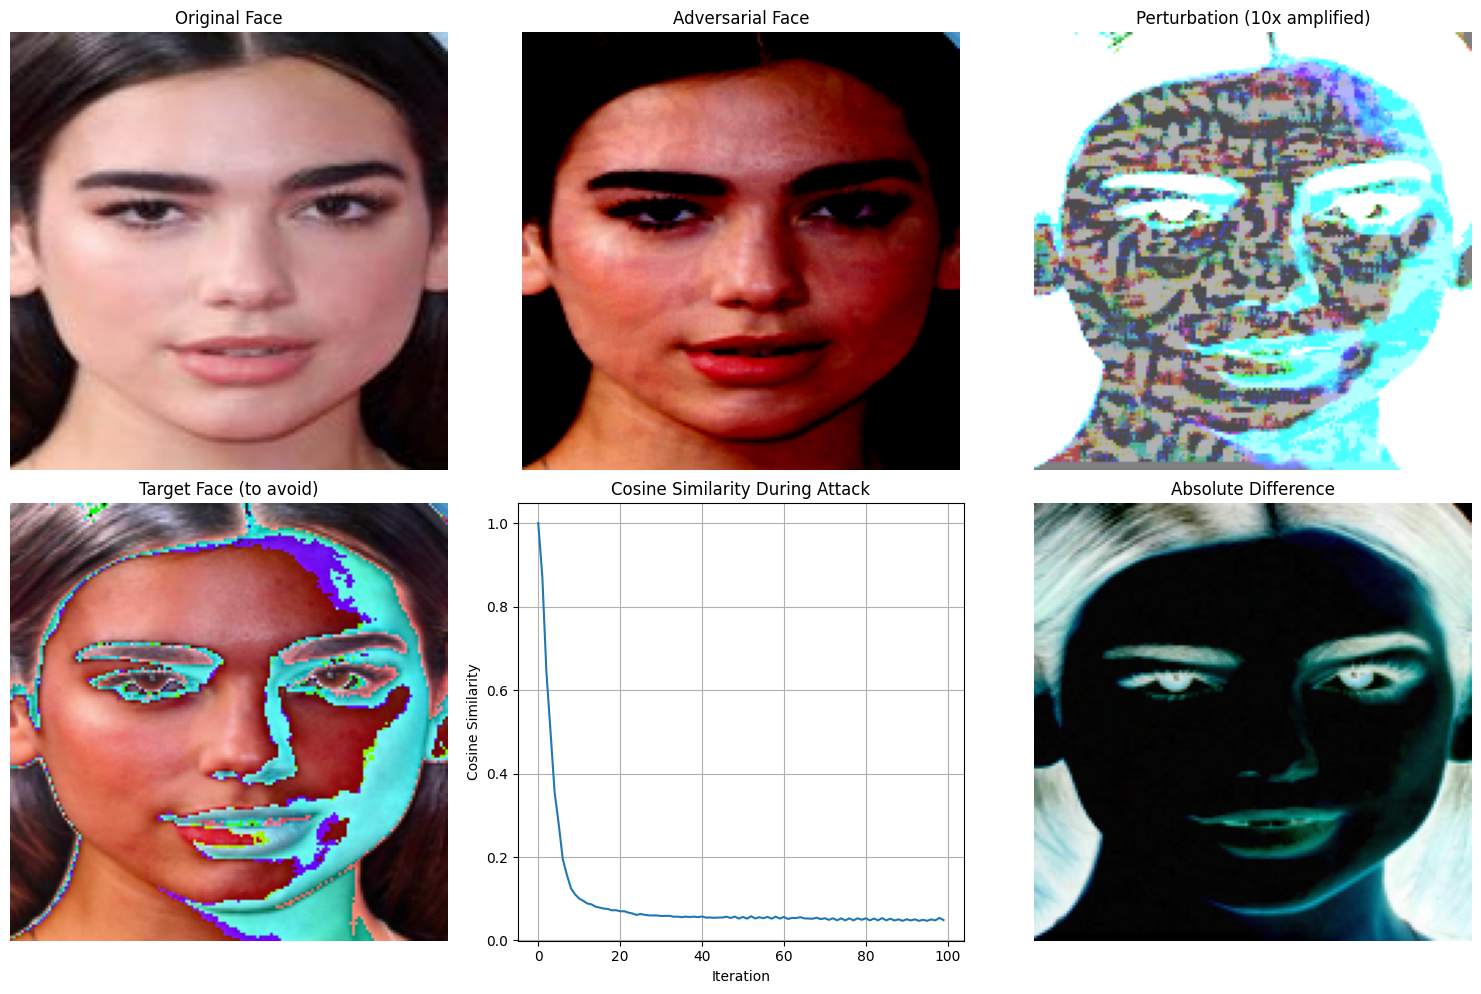


Adversarial image saved as 'adversarial_face.jpg'

Self-similarity test:
Original vs Original: 1.0000
Adversarial vs Original: 0.0536
Identity preservation: 0.0536 (higher is better for preserving identity)


In [10]:
# Load the pre-trained FaceNet model
model = InceptionResnetV1(pretrained='vggface2').eval()

# Load and align face with MTCNN
mtcnn = MTCNN(image_size=160, margin=20, keep_all=False)
img = Image.open('face4.jpg')
face_tensor = mtcnn(img)  # outputs 3x160x160 tensor
img2 = Image.open('face4.jpg')
face2_tensor = mtcnn(img2)
mtcnn(img, save_path="aligned_face.jpg") # Save unchanged, alligned face for cleaner output comparison

# Get original embeddings
with torch.no_grad():
    original_emb1 = model(face_tensor.unsqueeze(0))
    emb2 = model(face2_tensor.unsqueeze(0))

# Original similarity
original_sim = torch.nn.functional.cosine_similarity(original_emb1, emb2).item()
print(f"Original cosine similarity: {original_sim:.4f}")

# Perform PGD attack to minimize similarity with face2
print("\nPerforming PGD attack to minimize similarity...")
adversarial_face, perturbation, similarities = pgd_attack(
    model=model,
    image_tensor=face_tensor,
    target_embedding=emb2,
    epsilon=0.02,  # Maximum perturbation
    alpha=0.01,   # Step size
    num_iter=100, # Number of iterations
    minimize=True # Minimize similarity
)

# Evaluate adversarial example
with torch.no_grad():
    adv_embedding = model(adversarial_face.unsqueeze(0))
    final_similarity = torch.nn.functional.cosine_similarity(adv_embedding, emb2).item()

print(f"\nResults:")
print(f"Original similarity: {original_sim:.4f}")
print(f"Final similarity: {final_similarity:.4f}")
print(f"Similarity reduction: {original_sim - final_similarity:.4f}")
print(f"Perturbation L_inf norm: {torch.max(torch.abs(perturbation)).item():.4f}")
print(f"Perturbation L2 norm: {torch.norm(perturbation).item():.4f}")

# Visualization
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Convert tensors to PIL images for display
to_pil = T.ToPILImage()

# Original image
#original_pil = to_pil(face_tensor)
original_pil = Image.open('aligned_face.jpg')
axes[0, 0].imshow(original_pil)
axes[0, 0].set_title('Original Face')
axes[0, 0].axis('off')

# Adversarial image
adversarial_pil = to_pil(adversarial_face)
axes[0, 1].imshow(adversarial_pil)
axes[0, 1].set_title('Adversarial Face')
axes[0, 1].axis('off')

# Perturbation (amplified for visualization)
perturbation_vis = perturbation * 10 + 0.5  # Amplify and center for visibility
perturbation_vis = torch.clamp(perturbation_vis, 0, 1)
perturbation_pil = to_pil(perturbation_vis)
axes[0, 2].imshow(perturbation_pil)
axes[0, 2].set_title('Perturbation (10x amplified)')
axes[0, 2].axis('off')

# Target face (face2)
target_pil = to_pil(face2_tensor)
axes[1, 0].imshow(target_pil)
axes[1, 0].set_title('Target Face (to avoid)')
axes[1, 0].axis('off')

# Similarity over iterations
axes[1, 1].plot(similarities)
axes[1, 1].set_title('Cosine Similarity During Attack')
axes[1, 1].set_xlabel('Iteration')
axes[1, 1].set_ylabel('Cosine Similarity')
axes[1, 1].grid(True)

# Difference image
diff_image = torch.abs(adversarial_face - face_tensor)
diff_pil = to_pil(diff_image)
axes[1, 2].imshow(diff_pil)
axes[1, 2].set_title('Absolute Difference')
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

# Optional: Save adversarial image
adversarial_pil.save('adversarial_face.jpg')
print(f"\nAdversarial image saved as 'adversarial_face.jpg'")

# Test against original face (self-similarity)
with torch.no_grad():
    original_self_sim = torch.nn.functional.cosine_similarity(original_emb1, original_emb1).item()
    adv_self_sim = torch.nn.functional.cosine_similarity(adv_embedding, original_emb1).item()

print(f"\nSelf-similarity test:")
print(f"Original vs Original: {original_self_sim:.4f}")
print(f"Adversarial vs Original: {adv_self_sim:.4f}")
print(f"Identity preservation: {adv_self_sim:.4f} (higher is better for preserving identity)")


Results:
Original similarity: 1.0000
Final similarity: 0.0459
Similarity reduction: 0.9541
Perturbation L_inf norm: 0.9961
Perturbation L2 norm: 118.5430


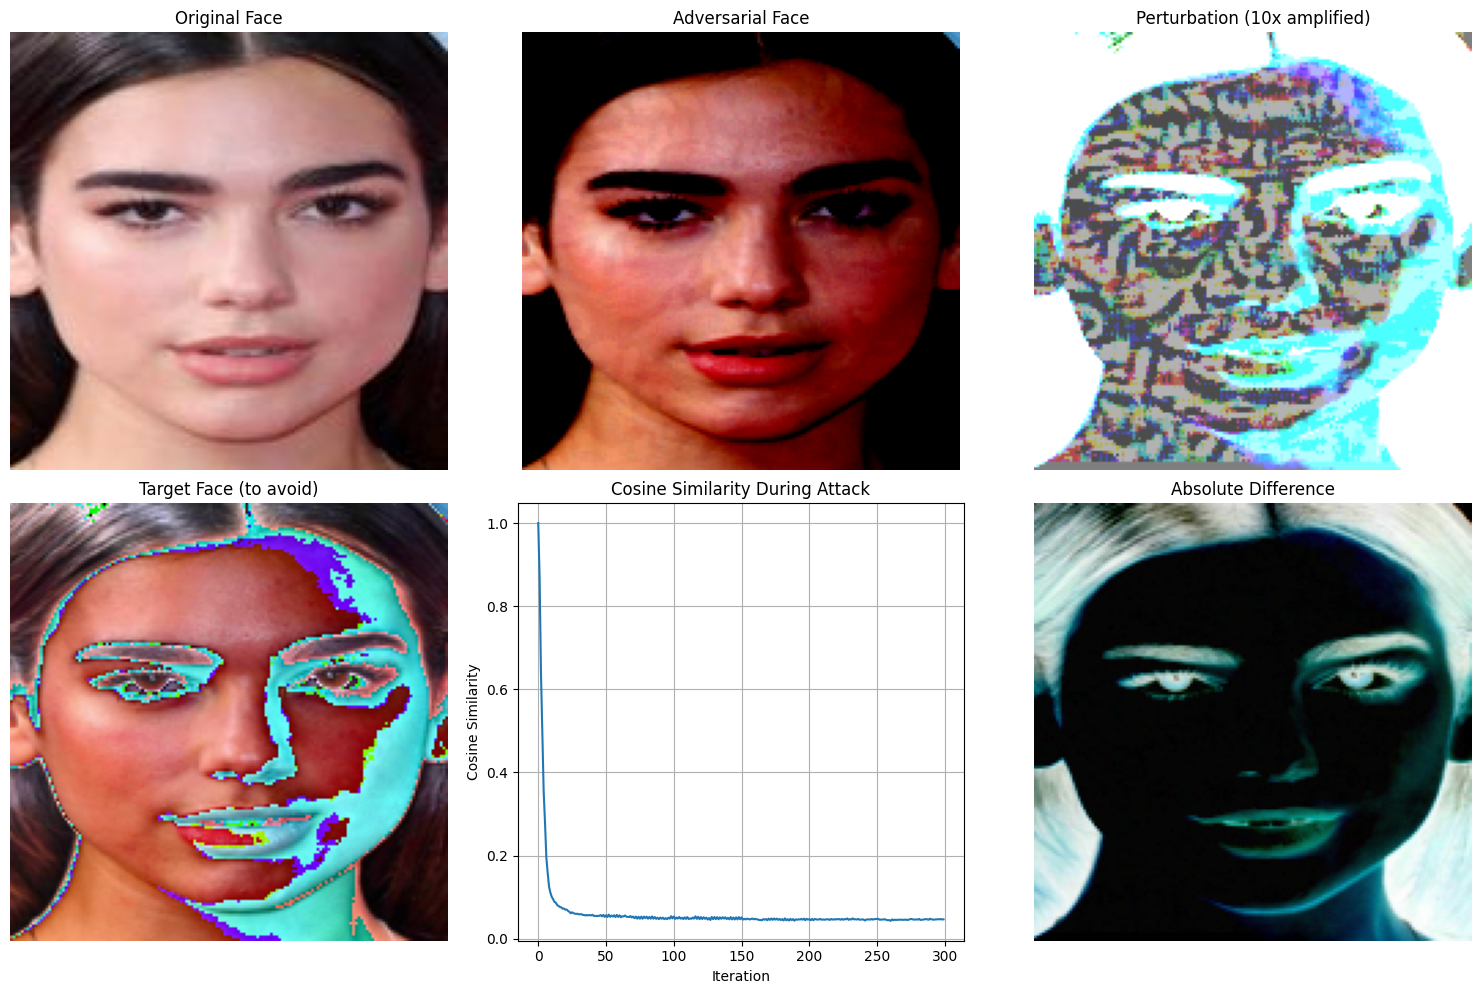


Adversarial image saved as 'adversarial_face.jpg'

Self-similarity test:
Original vs Original: 1.0000
Adversarial vs Original: 0.0459
Identity preservation: 0.0459 (higher is better for preserving identity)


In [59]:
print(f"\nResults:")
print(f"Original similarity: {original_sim:.4f}")
print(f"Final similarity: {final_similarity:.4f}")
print(f"Similarity reduction: {original_sim - final_similarity:.4f}")
print(f"Perturbation L_inf norm: {torch.max(torch.abs(perturbation)).item():.4f}")
print(f"Perturbation L2 norm: {torch.norm(perturbation).item():.4f}")

# Visualization
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Convert tensors to PIL images for display
to_pil = T.ToPILImage()

# Original image
#original_pil = to_pil(face_tensor)
original_pil = Image.open('aligned_face.jpg')
axes[0, 0].imshow(original_pil)
axes[0, 0].set_title('Original Face')
axes[0, 0].axis('off')

# Adversarial image
adversarial_pil = to_pil(adversarial_face)
axes[0, 1].imshow(adversarial_pil)
axes[0, 1].set_title('Adversarial Face')
axes[0, 1].axis('off')

# Perturbation (amplified for visualization)
perturbation_vis = perturbation * 10 + 0.5  # Amplify and center for visibility
perturbation_vis = torch.clamp(perturbation_vis, 0, 1)
perturbation_pil = to_pil(perturbation_vis)
axes[0, 2].imshow(perturbation_pil)
axes[0, 2].set_title('Perturbation (10x amplified)')
axes[0, 2].axis('off')

# Target face (face2)
target_pil = to_pil(face2_tensor)
axes[1, 0].imshow(target_pil)
axes[1, 0].set_title('Target Face (to avoid)')
axes[1, 0].axis('off')

# Similarity over iterations
axes[1, 1].plot(similarities)
axes[1, 1].set_title('Cosine Similarity During Attack')
axes[1, 1].set_xlabel('Iteration')
axes[1, 1].set_ylabel('Cosine Similarity')
axes[1, 1].grid(True)

# Difference image
diff_image = torch.abs(adversarial_face - face_tensor)
diff_pil = to_pil(diff_image)
axes[1, 2].imshow(diff_pil)
axes[1, 2].set_title('Absolute Difference')
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

# Optional: Save adversarial image
adversarial_pil.save('adversarial_face.jpg')
print(f"\nAdversarial image saved as 'adversarial_face.jpg'")

# Test against original face (self-similarity)
with torch.no_grad():
    original_self_sim = torch.nn.functional.cosine_similarity(original_emb1, original_emb1).item()
    adv_self_sim = torch.nn.functional.cosine_similarity(adv_embedding, original_emb1).item()

print(f"\nSelf-similarity test:")
print(f"Original vs Original: {original_self_sim:.4f}")
print(f"Adversarial vs Original: {adv_self_sim:.4f}")
print(f"Identity preservation: {adv_self_sim:.4f} (higher is better for preserving identity)")

In [39]:
def reconstruct_full_image(original_pil_img, adversarial_face_tensor, bbox, margin=20):
    """
    Insert the adversarial face back into the original full image
    
    Args:
        original_pil_img: Original PIL image
        adversarial_face_tensor: Adversarial face tensor (3, 160, 160)
        bbox: Bounding box from MTCNN [x1, y1, x2, y2]
        margin: Margin used in MTCNN (should match the margin used during extraction)
    
    Returns:
        PIL image with adversarial face inserted
    """
    
    # Convert adversarial face tensor to PIL image
    to_pil = T.ToPILImage()
    adv_face_pil = to_pil(adversarial_face_tensor)
    
    # Calculate the region in the original image where the face should be placed
    # MTCNN adds margin around the detected face, so we need to account for that
    x1, y1, x2, y2 = bbox[0]
    
    # Add margin to get the full region that was extracted
    margin_x = margin
    margin_y = margin
    
    # Calculate the region coordinates with margin
    region_x1 = max(0, int(x1 - margin_x))
    region_y1 = max(0, int(y1 - margin_y))
    region_x2 = min(original_pil_img.width, int(x2 + margin_x))
    region_y2 = min(original_pil_img.height, int(y2 + margin_y))
    
    # Resize adversarial face to match the region size
    region_width = region_x2 - region_x1
    region_height = region_y2 - region_y1
    adv_face_resized = adv_face_pil.resize((region_width, region_height), Image.LANCZOS)
    
    # Create a copy of the original image
    result_img = original_pil_img.copy()
    
    # Paste the adversarial face into the original image
    result_img.paste(adv_face_resized, (region_x1, region_y1))
    
    return result_img

face_bbox, prob = mtcnn.detect(img)
result = reconstruct_full_image(original_pil, adversarial_face, face_bbox)

ValueError: height and width must be > 0

In [65]:
mtcnn = MTCNN(image_size=160, margin=20)
mtcnn(img, save_path="aligned_face.jpg")

tensor([[[-0.3086, -0.4102, -0.3164,  ...,  0.2695,  0.3086,  0.3086],
         [-0.3711, -0.3008, -0.4023,  ...,  0.2227,  0.2695,  0.3164],
         [-0.3164, -0.4102, -0.4648,  ...,  0.2695,  0.2383,  0.2617],
         ...,
         [-0.8555, -0.6992, -0.2617,  ..., -0.9102, -0.9102, -0.9102],
         [-0.2930,  0.2070,  0.5664,  ..., -0.8867, -0.8867, -0.8633],
         [ 0.6055,  0.7461,  0.7852,  ..., -0.9258, -0.9023, -0.8633]],

        [[-0.3008, -0.4727, -0.4102,  ...,  0.5586,  0.5977,  0.5977],
         [-0.4336, -0.4102, -0.4961,  ...,  0.5117,  0.5586,  0.6055],
         [-0.4102, -0.5117, -0.5508,  ...,  0.5430,  0.5117,  0.5508],
         ...,
         [-0.9492, -0.8477, -0.4961,  ..., -0.9961, -0.9805, -0.9727],
         [-0.5195, -0.1055,  0.2070,  ..., -0.9727, -0.9648, -0.9414],
         [ 0.2305,  0.3633,  0.4102,  ..., -0.9805, -0.9727, -0.9492]],

        [[-0.2383, -0.4492, -0.4023,  ...,  0.7695,  0.8086,  0.8164],
         [-0.3945, -0.3867, -0.4805,  ...,  0